In [1]:
import warnings
warnings.filterwarnings("ignore")

import pyspark.sql
from pyspark.sql.functions import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from prepare import wrangle_311_data

spark = pyspark.sql.SparkSession.builder.getOrCreate()

## Answer the questions below by using a combination of the techniques discussed in the lesson that you think is appropriate.

In [2]:
# wrangling data
df = wrangle_311_data()

In [3]:
# previewing data
df.show(1, vertical=True)

-RECORD 0------------------------------------
 source_id            | svcCRMLS             
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 00:42:00  
 SLA_due_date         | 9/26/20 0:42         
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 request_address      | 2315  EL PASO ST,... 
 council_district     | 5                    
 case_due_date        | 2018-01-01 00:42:00  
 department           | Animal Care Services 
 dept_subject_to_SLA  | true                 
 source_username      | svcCRMLS             
only showing top 1 row



### How many different cases are there, by department?

In [4]:
# grouping by department and counting rows
(df.groupBy("department").count()).show()

+--------------------+------+
|          department| count|
+--------------------+------+
|         Solid Waste|286287|
|Animal Care Services|119362|
|Trans & Cap Impro...| 97841|
|  Parks & Recreation| 19964|
|    Customer Service|  2889|
|        Metro Health|  5313|
|        City Council|    34|
|DSD/Code Enforcement|323579|
+--------------------+------+



Text(0.5, 0, 'Number of Cases')

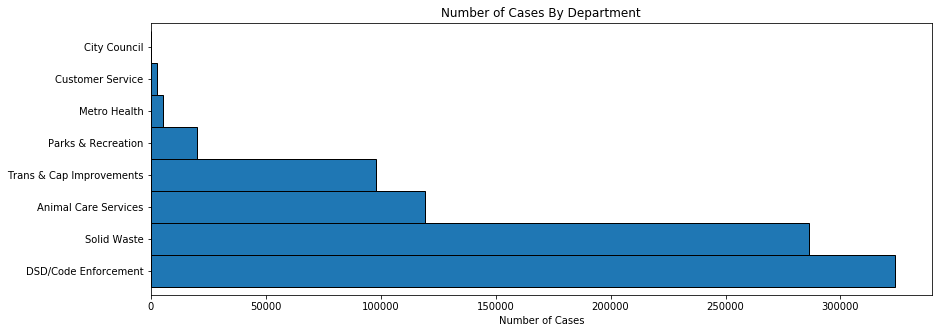

In [5]:
# using code above to aggregate
(
    df.groupBy("department")
    .count()
    # passing to pandas to create plot
    .toPandas()
    .set_index("department")["count"]
    .sort_values(ascending=False)
    .plot.barh(width=1, edgecolor="black", figsize=(14, 5))
)

# setting plot title and axis labels
plt.title("Number of Cases By Department")
plt.ylabel("")
plt.xlabel("Number of Cases")

### Does the percentage of cases that are late vary by department?

In [6]:
#df.groupby('department').count().show()

In [7]:
#df.filter(df.case_late == True).groupby('department').count().show()

### On average, how late are the late cases by department?

In [8]:
# filtering for cases that are currently late
# grouping by department
# aggregating avg number of days late
df.filter(df.case_late == True).groupby('department').agg((mean(df.num_days_late)).alias('avg_days_late')).show()

+--------------------+------------------+
|          department|     avg_days_late|
+--------------------+------------------+
|         Solid Waste| 7.147172789557422|
|Animal Care Services| 23.44672963473822|
|Trans & Cap Impro...| 10.66295045507867|
|  Parks & Recreation|22.427807192724128|
|    Customer Service| 88.18248182589824|
|        Metro Health| 6.494699602827868|
|DSD/Code Enforcement| 49.50633998635033|
+--------------------+------------------+



Text(0, 0.5, 'Department Name')

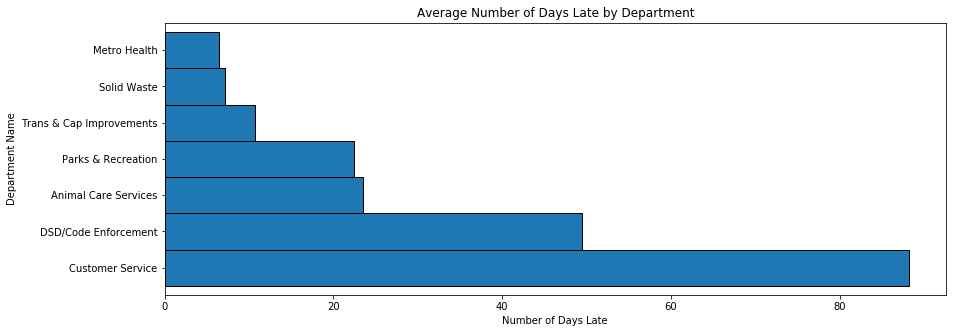

In [9]:
# using code above to aggregate
(
    df.filter(df.case_late == True).groupby('department').agg((mean(df.num_days_late)).alias('avg_days_late'))
    # passing to pandas to create plot
    .toPandas()
    .set_index("department")["avg_days_late"]
    .sort_values(ascending=False)
    .plot.barh(width=1, edgecolor="black", figsize=(14, 5))
)

# setting plot title and x axis label
plt.title("Average Number of Days Late by Department")
plt.xlabel("Number of Days Late")
plt.ylabel("Department Name")

### What is the service type that is the most late? 

In [10]:
# filtering for cases that are currently late
# grouping by service request type
# aggregating avg number of days late
# observing top 10
df.filter(df.case_late == True).groupby('service_request_type')\
.agg((mean(df.num_days_late)).alias('avg_days_late')).sort(desc('avg_days_late')).show(10)

+--------------------+------------------+
|service_request_type|     avg_days_late|
+--------------------+------------------+
|Zoning: Recycle Yard|210.89201994318182|
|  Zoning: Junk Yards|200.20517608494276|
|Structure/Housing...|190.20707698509804|
|Donation Containe...|171.09115313942618|
|Storage of Used M...|163.96812829714287|
|Labeling for Used...|162.43032902285717|
|Record Keeping of...|153.99724039428568|
|Signage Requied f...|151.63868055333333|
|Traffic Signal Gr...|137.64583330000002|
|License Requied U...|128.79828704142858|
+--------------------+------------------+
only showing top 10 rows



Text(0.5, 0, 'Average Number of Days Late')

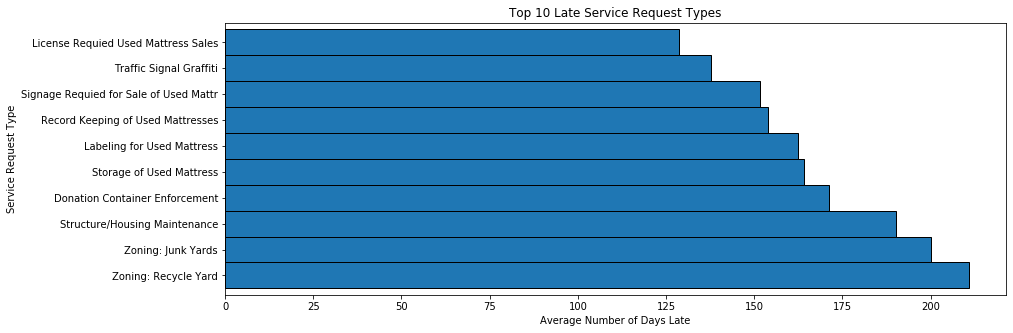

In [11]:
(
    # using code above to aggregate
    df.filter(df.case_late == True).groupby('service_request_type').agg((mean(df.num_days_late)).alias('avg_days_late'))\
    .sort(desc('avg_days_late'))
    # passing to pandas to create plot
    .toPandas()
    .head(10)
    .set_index("service_request_type")["avg_days_late"]
    .sort_values(ascending=False)
    .plot.barh(width=1, edgecolor="black", figsize=(14, 5))
)

# setting plot title and axis labels
plt.title("Top 10 Late Service Request Types")
plt.ylabel("Service Request Type")
plt.xlabel("Average Number of Days Late")

### Just for Parks & Rec?

In [27]:
df.filter(df.case_late == True).filter(df.department == 'Parks & Recreation').groupby('service_request_type')\
.agg((mean(df.num_days_late)).alias('avg_days_late')).sort(desc('avg_days_late')).show()

+--------------------+------------------+
|service_request_type|     avg_days_late|
+--------------------+------------------+
|Amenity Park Impr...| 76.60603677123078|
|Major Park Improv...| 75.79450367282352|
|Reservation Assis...|       66.03116319|
|Park Building Mai...| 59.36746980269565|
| Sportfield Lighting|52.034858419575656|
|          Electrical|  42.9519716583451|
|        Tree Removal| 40.28404224560714|
|Landscape Mainten...| 38.86797941326316|
|     Heavy Equipment| 38.56625730831579|
|Miscellaneous Par...| 33.62472491253489|
|Tree Trimming/Mai...|30.563700002936045|
|General Building ...|28.192905974561906|
|             Masonry|27.989420392890622|
|            Painting|25.404551756282608|
|    Sign Maintenance|22.281778663588234|
|   Fence/Gate Repair|20.366796601056606|
|Small Equipment R...|      19.644149305|
|Plumbing/Drinking...| 19.61590306943038|
|               Pools|19.489430630709677|
|            Plumbing|18.621826175298462|
+--------------------+------------

Text(0.5, 0, 'Average Number of Days Late')

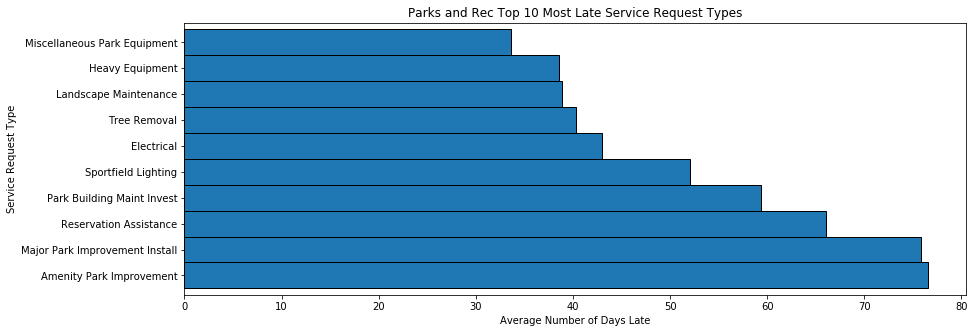

In [25]:
(
    # using code above to aggregate
    df.filter(df.case_late == True).filter(df.department == 'Parks & Recreation').groupby('service_request_type')\
    .agg((mean(df.num_days_late)).alias('avg_days_late')).sort(desc('avg_days_late'))
    # passing to pandas to create plot
    .toPandas()
    .head(10)
    .set_index("service_request_type")["avg_days_late"]
    .sort_values(ascending=False)
    .plot.barh(width=1, edgecolor="black", figsize=(14, 5))
)

# setting plot title and axis labels
plt.title("Parks and Rec Top 10 Most Late Service Request Types")
plt.ylabel("Service Request Type")
plt.xlabel("Average Number of Days Late")

### For the DSD/Code Enforcement department, what are the most common service request types? Look at other departments too.

In [ ]:
df.toPandas()

### Does whether or not its a weekend matter for when a case is opened/closed?

### On average, how many cases are opened a day for the Customer Service department?

### Does the number of service requests for the solid waste department vary by day of the week?